<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP0/TP0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático
# Trabajo práctico 0

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- July 06th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import random
import math
from sympy import *

import torch.distributions as distrib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg

# Pandas library for reading csvs
from pandas import read_csv
import numpy as np

# Scikit binary classification algorithms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split as tts

from skimage import color
from functools import reduce
import operator
import statistics

# 1) La convolución en una dimensión (100 puntos)




Plot Speed Signal for Sample Values


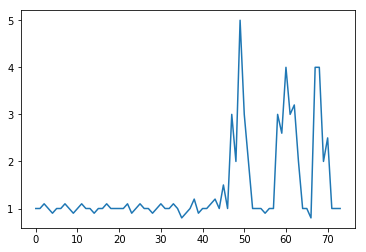


Plot Speed Signal after 1D Convolution for m=3


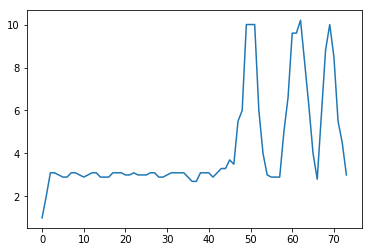


Plot Speed Signal after 1D Convolution for m=5


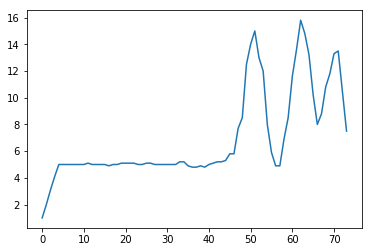


Plot Speed Signal after 1D Convolution for filter [-5, 0, 5]


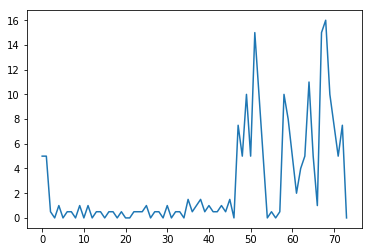


Plot Speed Signal with threshold after 1D Convolution for filter [-5, 0, 5]


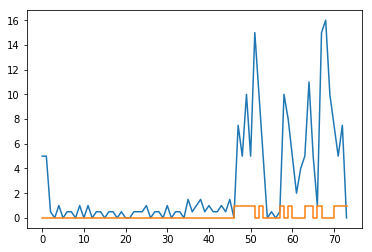


Plot Speed Signal after 1D Convolution for filter [-8, 0, 8]


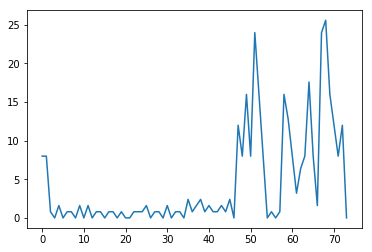


Plot Speed Signal with threshold after 1D Convolution for filter [-8, 0, 8]


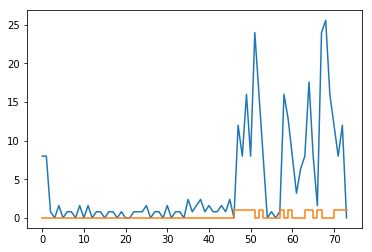

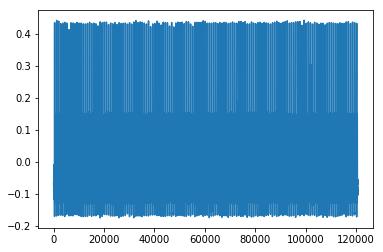


Plot Autocorrelation from Oscilation Signal


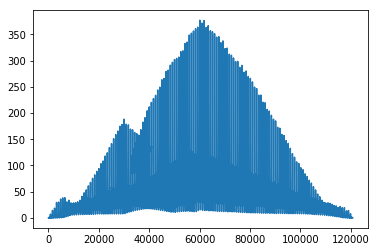

In [108]:
def oneDimensionConvolution():  
  # Set CSV Path
  speedDatasetPath = 'https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/speed.csv'
  oscilationsDatasetPath = 'https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/ecg1.csv'
    
  # Read the dataset from csv
  speedDataset = read_csv(speedDatasetPath, header=None)
  oscilationsDataset = read_csv(oscilationsDatasetPath, header=None)
  
  # Set number of Samples and Samples Values
  numberOfSpeedSamples = speedDataset.columns.values
  speedSampleValues = speedDataset[0:].values.tolist()[0]
  speedValuesTensor = torch.tensor(speedSampleValues)

  # Set number of Samples and Samples Values
  oscilationSampleValues = oscilationsDataset.iloc[:,0].tolist()
  numberOfOscilationSamples = oscilationsDataset.iloc[:,0].index.tolist()
  oscilationValuesTensor = torch.tensor(oscilationSampleValues)

  # Exercise 1.a
  def plotSignal(speedValues, numberOfSamples):
    """
    Graph the Speed Signal
    """
    # Plot
    plt.plot(numberOfSamples,speedValues)
    plt.show()
  
  def calculateBinarySignal(speedValues, threshold=0.4):
    """
    Generate Binary Signal
    """
    initialEvent = False
    binarySignal = []
    maxValue = max(speedValues)
    for speedValue in speedValues:
      if speedValue > threshold*maxValue and initialEvent == False:
        binarySignal.append(1)
        initialEvent = True
      elif speedValue <= threshold*maxValue and initialEvent == True:
        binarySignal.append(1)
        initialEvent = False
      else:
        binarySignal.append(0)
    return binarySignal
    
  def plotSignalWithThreshold(speedValues, numberOfSamples):
    """
    Graph the Speed Signal
    """
    binarySignal = calculateBinarySignal(speedValues, threshold=0.4)
  
    # Plot
    plt.plot(numberOfSamples, speedValues)
    plt.step(numberOfSamples, binarySignal)
    plt.show()

  # Exercise 1.b
  def convolucionar1D(f, g):
    gSize = list(g.size())[0]
    fSize = list(f.size())[0]
    result = torch.zeros(fSize)

    # Append zeros to filter in zero padding
    g = torch.from_numpy(np.pad(g.numpy(), (0, fSize - gSize), 'constant'))

    for index in range(1, fSize+1):
      # Split and reverse Filter: g[n-m]
      splitFilter = g[0:index]
      reversedFilter = np.flip(splitFilter.numpy(), 0).copy()

      # Append zeros to reverse filter in zero padding
      reversedTensor = torch.from_numpy(np.pad(reversedFilter, (0, fSize - gSize), 'constant'))
      
      # Dot product and append result
      dot_product = torch.dot(f[0:index], reversedTensor[0:index])
      result[index-1] = abs(dot_product)

    return result
  
  # Exercise 1.b
  def autocorrelacionar(f):
    # Plot ecg signal
    plotSignal(oscilationSampleValues, numberOfOscilationSamples)
    
    # Calculate correlation
    fSize = list(f.size())[0]
    result = torch.zeros(fSize)
    
    # Index to split f
    i = 1
    for index in range(0, fSize):
      splitFilter = f[index:index+i]

      # Append zeros to u in zero padding
      splitFilterTensor = torch.from_numpy(np.pad(splitFilter, (0, fSize - list(splitFilter.size())[0]), 'constant'))
      
      # Dot product and append result
      dot_product = torch.dot(f[0:index+1], splitFilterTensor[0:index+1])
      result[index] = abs(dot_product)
      
      # Update index used to split
      i = i + 1
      
    return result

    
  # Test exercise 1.1 : Plot Speed Signal
  print("\nPlot Speed Signal for Sample Values")
  plotSignal(speedSampleValues, numberOfSpeedSamples)
  
  # Test exercise 1.2 : Calculate 1D convolution for m = 3
  g = torch.ones(3)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal after 1D Convolution for m=3")
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.2 : Calculate 1D convolution for m = 5
  g = torch.ones(5)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal after 1D Convolution for m=5")
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 5
  g = [-5., 0., 5.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal after 1D Convolution for filter [-5, 0, 5]")
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 5 with threshold signal
  g = [-5., 0., 5.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal with threshold after 1D Convolution for filter [-5, 0, 5]")
  plotSignalWithThreshold(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 8
  g = [-8., 0., 8.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal after 1D Convolution for filter [-8, 0, 8]")
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 8 with threshold signal
  g = [-8., 0., 8.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  print("\nPlot Speed Signal with threshold after 1D Convolution for filter [-8, 0, 8]")
  plotSignalWithThreshold(convolutionResult.tolist(), numberOfSpeedSamples)
  
  # Test exercise 1.4
  autoCorrelationResult = autocorrelacionar(oscilationValuesTensor)
  print("\nPlot Autocorrelation from Oscilation Signal")
  plotSignal(autoCorrelationResult.tolist(), numberOfOscilationSamples)
 

# Test exercise 1
oneDimensionConvolution()
  
  
 

# 2) La convolución en dos dimensiones (20 puntos)

Kernel 1 Output: 

Show image: 



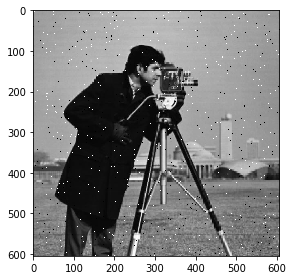


Show image: 



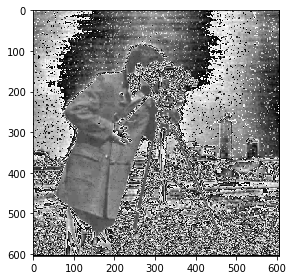

Kernel 2 Output: 

Show image: 



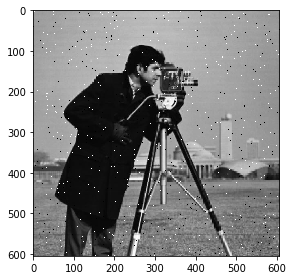


Show image: 



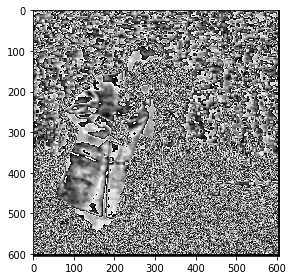

Median Filter with c=3 Output: 

Show image: 



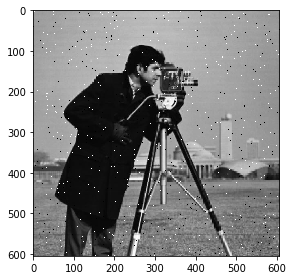


Show image: 



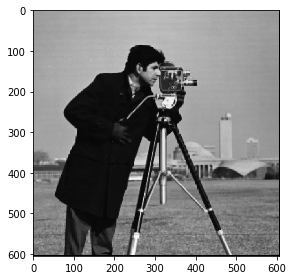

Median Filter with c=7 Output: 

Show image: 



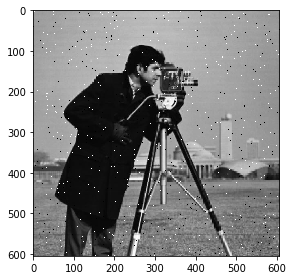


Show image: 



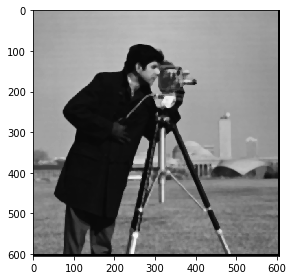

In [166]:
def showImage(image):
  print("\nShow image: \n")
  io.imshow(image) 
  io.show()
  
def convolucionar2D(kernel):
  image = io.imread('https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/noisy.bmp', as_gray=True)
  showImage(image)
  
  # Convert the image to grayscale
  image = color.rgb2gray(image)
  
  # Flip the kernel
  kernel = np.flipud(np.fliplr(kernel))
  
  # Create matrix with zeros to save the convolution output
  convolutionResult = np.zeros_like(image)
  
  # Get the number of kernel columns and rows
  kernelColumns= np.size(kernel,1)
  kernelRows= np.size(kernel,0)
  
  # Loop over every pixel of the image
  for x in range(image.shape[1]):
      for y in range(image.shape[0]):
          if x + kernelRows <= image.shape[1] and y + kernelColumns <= image.shape[0]:
            # element-wise multiplication of the kernel and the image
            convolutionResult[y,x]=(kernel*image[y:y+kernelColumns,x:x+kernelRows]).sum()
  
  # Show filtered image
  showImage(convolutionResult)

def filtrarMedianas(c=3):
  image = io.imread('https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/noisy.bmp', as_gray=True)
  showImage(image)
  
  # Convert the image to grayscale
  image = color.rgb2gray(image)
  
  # Create matrix with zeros to save the median filter output
  medianFilterResult = np.zeros_like(image)
  
  # Get the number of kernel columns and rows
  filterColumns= c
  filterRows= c
  
  # Loop over every pixel of the image
  for x in range(image.shape[0]):
      for y in range(image.shape[1]):
          if x + filterRows <= image.shape[0] and y + filterColumns <= image.shape[1]:
            imagePortion = image[x:x+filterRows, y:y+filterColumns]
            imagePortion = reduce(operator.concat, imagePortion.tolist())
            medianFilterResult[x, y]=statistics.median(imagePortion)
  
  # Show filtered image
  showImage(medianFilterResult)


# Test 2D Convolution
kernel1 = np.array([[1,1,1],[1,1,1],[1,1,1]])
kernel2 = np.array([[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1]])

print("Kernel 1 Output: ")
convolucionar2D(kernel1)

print("Kernel 2 Output: ")
convolucionar2D(kernel2)

print("Median Filter with c=3 Output: ")
filtrarMedianas()

print("Median Filter with c=7 Output: ")
filtrarMedianas(c=7)